In [1]:
import sys
sys.path.append('../')

In [2]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [3]:
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.vocab import *
from mrl.callbacks import *
from mrl.callbacks.template_cb import *
from mrl.agent import *
from mrl.policy_gradient import *
from mrl.loss import *
from mrl.sampler import *
from mrl.environment import *
from mrl.reward import *

In [4]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)

In [5]:
df = pd.read_csv('../nbs/files/smiles.csv')
# vocab = CharacterVocab(SMILES_CHAR_VOCAB)

vocab = FuncVocab(SELFIES_VOCAB, split_selfie,
                  prefunc=smile_to_selfie, postfunc=selfie_to_smile)

ds = Text_Dataset(df.smiles.values, vocab)
loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_selfies.pt'))


# df = pd.read_csv('../nbs/files/smiles.csv')
# vocab = CharacterVocab(SMILES_CHAR_VOCAB)

# # ds = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
# ds = Vec_To_Text_Dataset([('C','')], vocab, ECFP6)
# loss = CrossEntropy()


# encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
# d_vocab = len(vocab.itos)
# d_embedding = 256
# d_hidden = 1024
# d_latent = 512
# n_layers = 3
# input_dropout = 0.
# lstm_dropout = 0.
# condition_hidden = True
# condition_output = False
# bos_idx = vocab.stoi['bos']
# norm_latent = True

# model = Conditional_LSTM_LM(encoder, 
#                                d_vocab, 
#                                d_embedding, 
#                                d_hidden, 
#                                d_latent, 
#                                n_layers,
#                                input_dropout, 
#                                lstm_dropout, 
#                                norm_latent,
#                                condition_hidden, 
#                                condition_output, 
#                                bos_idx)

# model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

# df = pd.read_csv('../nbs/files/smiles.csv')
# vocab = CharacterVocab(SMILES_CHAR_VOCAB)

# ds = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
# loss = VAELoss()

# d_vocab = len(vocab.itos)
# d_embedding = 256
# encoder_d_in = 2048
# encoder_dims = [1024, 512]
# encoder_drops = [0.1, 0.1]
# d_hidden = 1024
# d_latent = 512
# n_layers = 3
# input_dropout = 0.
# lstm_dropout = 0.
# bidir = False
# condition_hidden = True
# condition_output = True
# bos_idx = vocab.stoi['bos']


# model = MLP_VAE(
#             d_vocab,
#             d_embedding,
#             encoder_d_in,
#             encoder_dims,
#             encoder_drops,
#             d_hidden,
#             n_layers,
#             d_latent,
#             input_dropout=input_dropout,
#             lstm_dropout=lstm_dropout,
#             condition_hidden=condition_hidden,
#             condition_output=condition_output,
#             prior=None,
#             bos_idx=bos_idx,
#             transition=None,
#         )

# model.load_state_dict(torch.load('../nbs/untracked_files/fp_vae_zinc.pt'))

# model.z_scale = 0.

agent = GenerativeAgent(model, vocab, loss, ds, opt_kwargs={'lr':1e-4},
                       base_update_iter=5, base_update=.97)

# freeze(agent.model)

In [7]:
def scale_sa(sa):
    return (10-sa)/9

In [8]:
template = Template([ValidityFilter(), SingleCompoundFilter()],
                    [QEDFilter(None, None, score=PassThroughScore()),
                     SAFilter(None, None, 
                              score=PropertyFunctionScore(scale_sa))], fail_score=-1.)

In [9]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]




# sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
# sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)

# samplers = [sampler1, sampler2]
        
    
# latents = torch.randn((1024, 512))

# sampler1 = LatentSampler(vocab, agent.model, latents, 'latent', 0, 1., gen_bs, opt_kwargs={'lr':1e-2})
# samplers = [sampler1]

# data_df = next(pd.read_csv('/home/dmai/smiles_datasets/shard_0.csv', chunksize=2000000))

# os.environ['ncpus'] = '64'
# data_df['score'] = template.eval_mols(data_df.smiles.values)
# os.environ['ncpus'] = '0'

# data_df = data_df[data_df.score>1.75]
        
# sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
# sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
# sampler3 = DatasetSampler(data_df.smiles.values, 400, 'zinc_data')

# samplers = [sampler1, sampler2, sampler3]


# data_df = next(pd.read_csv('/home/dmai/smiles_datasets/shard_0.csv', chunksize=1000000))
# sampler1 = DatasetSampler(data_df.smiles.values, 2000, 'zinc_data')
# sampler1 = ContrastiveSampler(sampler1, vocab, ds, agent.model, gen_bs, repeats=5)

# sampler2 = LogSampler('rewards', 15, 95, 400)

# samplers = [sampler1, sampler2]

In [10]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss1 = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})


# pg = TRPO(0.99, 4.)
# loss1 = PolicyLoss(pg, 'trpo', 
#                    value_head=ValueHead(256), 
#                    v_update_iter=2, 
#                    vopt_kwargs={'lr':1e-3})


# pg = PolicyGradient(discount=False, ratio=True)
# loss1 = PolicyLoss(pg, 'PG')


In [11]:
template_cb = TemplateCallback(template, prefilter=True)

# sf = FPSimilarity(ECFP6, tanimoto_rd, 0.2, 0.95, 0.05, -1.)


# template_cb = ContrastiveTemplate(sf, max_score=2., template=template, prefilter=True)

In [12]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [13]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')

r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(df.smiles.values, df.value.values/10, ECFP6)

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/aff_pred.pt')

r_model.eval();

freeze(r_model)


aff_reward = FunctionReward(r_agent.predict_data, 
                            'aff', 
                            weight=-10.)


In [14]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[aff_reward], loss_cbs=[loss1],
                 cbs=cbs)

In [15]:
env.fit(200, 90, 1000, 4)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
0,-6.881,1.468,1.000,1.000,200,1.000,1.000,-6.941,1.000,-8.349,0.554,-5.015,-2.535
4,-6.979,1.487,1.000,1.000,200,1.000,1.000,-6.890,1.000,-8.466,0.626,-4.614,-2.497
8,-6.924,1.471,1.000,1.000,200,1.000,1.000,-7.104,1.000,-8.395,0.588,-4.731,-2.395
12,-6.838,1.476,1.000,1.000,200,1.000,1.000,-6.917,1.000,-8.314,0.675,-4.909,-1.867
16,-6.784,1.462,1.000,1.000,200,1.000,1.000,-6.729,1.000,-8.246,0.587,-4.368,-2.684
20,-6.624,1.448,1.000,1.000,200,1.000,1.000,-6.329,1.000,-8.072,0.532,-4.392,-2.699
24,-6.775,1.447,1.000,1.000,200,1.000,1.000,-6.634,1.000,-8.223,0.610,-4.482,-3.399
28,-6.668,1.443,1.000,1.000,200,1.000,1.000,-6.705,1.000,-8.110,0.538,-4.581,-3.321
32,-6.969,1.454,1.000,1.000,200,1.000,1.000,-6.884,1.000,-8.423,0.639,-4.889,-2.555
36,-6.480,1.449,1.000,1.000,200,1.000,1.000,-6.396,1.000,-7.929,0.615,-4.096,-2.081


Epoch,Train Loss,Valid Loss,Time
0,0.62800,0.47515,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.46981,0.51251,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.40941,0.49417,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.33532,0.29638,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.31591,0.26948,00:03


In [15]:
env.fit(200, 90, 500, 4)

iterations,rewards,template,valid,diversity,bs,live_diversity,live_valid,live_rewards,live_new,aff,PPO,rewards_live_p90,rewards_live_max
1000,-3.064,1.278,1.000,0.975,200,0.967,1.000,-2.832,0.408,-4.343,0.389,-0.845,0.158
1004,-3.103,1.277,1.000,0.960,200,0.942,1.000,-2.979,0.342,-4.381,0.412,-1.033,-0.090
1008,-2.996,1.271,1.000,0.965,200,0.983,1.000,-2.609,0.333,-4.267,0.324,-0.595,0.404
1012,-2.836,1.266,1.000,0.975,200,0.983,1.000,-2.505,0.350,-4.102,0.356,-0.466,0.098
1016,-3.009,1.290,1.000,0.985,200,0.975,1.000,-2.739,0.408,-4.299,0.412,-0.740,0.326
1020,-2.774,1.292,1.000,0.970,200,0.967,1.000,-2.741,0.342,-4.065,0.466,-0.544,0.494
1024,-2.792,1.283,1.000,0.975,200,0.958,1.000,-2.629,0.283,-4.075,0.387,-0.642,0.494
1028,-2.837,1.250,1.000,0.995,200,1.000,1.000,-2.707,0.375,-4.086,0.387,-0.733,-0.028
1032,-2.747,1.289,1.000,0.965,200,0.958,1.000,-2.436,0.317,-4.036,0.402,-0.369,0.158
1036,-2.588,1.260,1.000,0.980,200,0.983,1.000,-2.369,0.308,-3.847,0.299,-0.576,-0.264


Epoch,Train Loss,Valid Loss,Time
0,0.27116,0.37541,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.31929,0.31228,00:03


In [16]:
log_df = log_to_df(env.log.log)

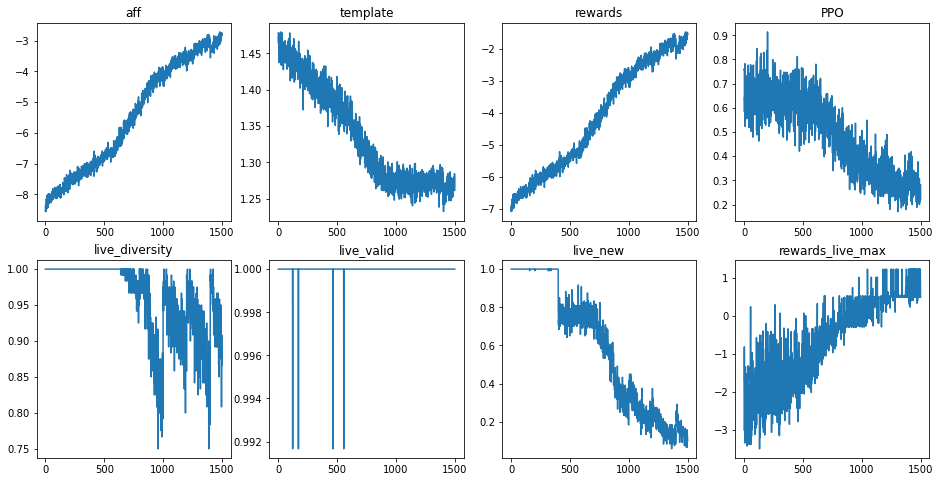

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
plot_vals = ['aff', 'template', 'rewards', 'PPO',
             'live_diversity', 'live_valid', 'live_new', 'rewards_live_max']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])

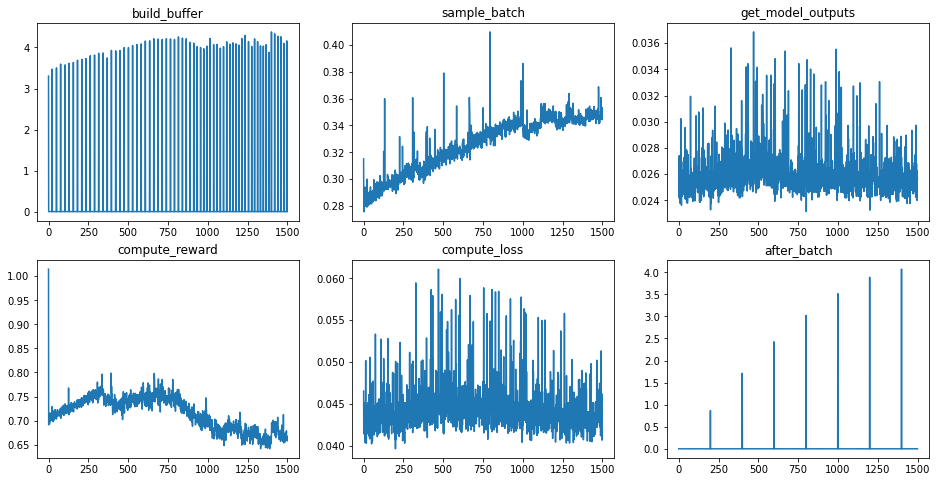

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(16,8))
plot_vals = ['build_buffer', 'sample_batch', 'get_model_outputs', 
             'compute_reward', 'compute_loss', 'after_batch']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.timelog[plot_vals[i]]))
    ax.set_title(plot_vals[i])

In [ ]:
    def fit(self, bs, sl, iters, report, cbs=None):
        if cbs is None:
            cbs = []
        self.register_cbs(cbs)
        self.bs = bs
        self.sl = sl
        self.report = report
        mb = master_bar(range(1))
        self.log.pbar = mb
        self.log.report = report
        self('before_train')
        for _ in mb:
            for step in progress_bar(range(iters), parent=mb):
                self.build_buffer()
                self.sample_batch()
                self.get_model_outputs()
                self.compute_reward()
                self.compute_loss()
                self.after_batch()
                
        self('after_train')
        self.remove_cbs(cbs)

In [ ]:
class PoolingHead(nn.Module):
    def __init__(self, d_in, dims, d_out, drops, outrange=None):
        super().__init__()
        
        self.layers = MLP_Encoder(d_in, dims, d_out, drops)
        self.outrange = outrange
        
    def forward(self, x, mask=None):
        # x - bs, sl, d
        # mask - bs, sl
        if mask is not None:
            lengths = mask.sum(-1)
            final_vals = x[torch.arange(x.shape[0]), lengths-1]
            pool1 = x.masked_fill(mask.unsqueeze(-1), 0).sum(1)/lengths.unsqueeze(-1)
            pool2 = x.masked_fill(mask.unsqueeze(-1), -float('inf')).max(1)[0]
        else:
            final_vals = x[:,-1]
            pool1 = x.mean(1)
            pool2 = x.max(1)[0]
            
        x = torch.cat([final_vals, pool1, pool2], 1)
        x = self.layers(x)
        
        if self.outrange is not None:
            x = torch.sigmoid(x) * (self.outrange[1]-self.outrange[0]) + self.outrange[0]
        
        return x
    
class Predictive_LSTM(nn.Module):
    def __init__(self, d_vocab, d_embedding, d_hidden, n_layers, d_out_lstm,
                 head_dims, head_drops, d_out, outrange=None,
                 lstm_drop=0., bidir=False,):
        super().__init__()
        
        self.embedding = nn.Embedding(d_vocab, d_embedding)
        self.lstm = LSTM(d_embedding, d_hidden, d_out_lstm, n_layers,
                                     bidir=bidir, dropout=lstm_drop)
        
        self.head = PoolingHead(d_out_lstm*3, head_dims, d_out, head_drops, outrange)

        
    def forward(self, x, hiddens=None, mask=None):
        
        x = self.embedding(x)
        encoded, hiddens = self.lstm(x, hiddens)
        output = self.head(encoded, mask)
        return output
    
    def freeze_encoder(self):
        for p in self.embedding.parameters():
            p.requires_grad_(False)
            
        for p in self.lstm.parameters():
            p.requires_grad_(False)
    
    def load_from_lm(self, lm_model):
        if hasattr(lm_model, 'block'):
            self.embedding.load_state_dict(lm_model.block.embedding.state_dict())
            self.lstm.load_state_dict(lm_model.block.lstm.state_dict())
        else:
            if hasattr(lm_model, 'lstm'):
                self.lstm.load_state_dict(lm_model.lstm.state_dict())
                
            if hasattr(lm_model, 'embedding'):
                self.embedding.load_state_dict(lm_model.embedding.state_dict())

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [ ]:
ds = TextDataset(['CCC'], vocab)

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
lstm_drop = 0.
lin_drop = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

lm_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
                lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

lm_model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_small.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
model = Predictive_LSTM(d_vocab, d_embedding, d_hidden, n_layers, d_embedding,
                        [512, 256], [0.1, 0.1], 1)

In [ ]:
model.load_from_lm(lm_model)

In [ ]:
next(model.lstm.parameters())

Parameter containing:
tensor([[ 0.0181,  0.0324,  0.0202,  ...,  0.0010,  0.0047,  0.0283],
        [-0.0101,  0.0228,  0.0193,  ..., -0.0366,  0.0038, -0.0540],
        [ 0.0537, -0.0437, -0.0073,  ...,  0.0270, -0.0121,  0.0504],
        ...,
        [ 0.0567,  0.0338, -0.0113,  ..., -0.0163,  0.0104,  0.0140],
        [ 0.0025,  0.0101,  0.0410,  ..., -0.0130, -0.0164, -0.0144],
        [ 0.0174,  0.0205,  0.0073,  ...,  0.0442, -0.0021,  0.0154]],
       requires_grad=True)



current roadmap
    python 3.7 upgrade?
    Do PR
    new branch
        change buffer
            hold sample aand score
            new event workflow
        update rewards
            make template callback a subset of reward
            put standardize/filter functions into new filtering events
    Do PR
    now we do documentation/update site
    combichem
    jtnnvae
    start working on other docs
        guides
        examples
    move to release v0
    


environment    
callbacks (base)
log/buffer callbacks
samplers
agent
rewards
losses
policy gradient

callbacks
    core
    logging
    template
    
agent
PG
losses
samplers
rewards





    

future modules
    combichem
    pharmacophore
    active learning
    new models
        jtnnvae
        flow based
    chemprop hooks
    huggingface hooks
    basic docking
        
project quality
    collab links
    google search on site
    more documentation

Use cases/examples
    basic drug design
    iterative drug design with dataset building
    drug design with docking proxy
    proteins/antibodies
    polymers
    catalyst
    materials
    
guides
    generative screening primer
    basics
        stuff about how bad score functions can be
    how to use callbacks
    basic drug design
    contrastive optimization
    latent/prior optimization
    training tips/tricks (callback stuff)
    
paapers to implement
    fastai guy - conditional lstm, contrastive
    moldqn - dqn sampler (rollout), agent is score function, dqn loss
    synthesis constrained? really same as DQN with different rolllout
    stoned selfies/genetic algorithm examples
    deep drug decoder/paul paper/other conditional generation